In [1]:
import sys
from pathlib import Path

# Add the project root (one level up from notebooks/) to sys.path
sys.path.append(str(Path().resolve().parent))

import importlib
from spine_score.src import extract, dataset, model
from pathlib import Path
import os 
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import glob
import torch

from spine_score.src.model import SimpleUNet3D, train_model, evaluate_model, print_metrics

In [2]:
# Reloads modules (run for development update with the notebook)
importlib.reload(extract) 
importlib.reload(dataset)
importlib.reload(model)

<module 'spine_score.src.model' from 'C:\\Users\\Maxtw\\OneDrive\\Desktop\\Final Project 521\\aai-521-final-project\\spine_score\\src\\model.py'>

In [3]:
# # defaults to extracting from /workspaces/data
# df = extract.extract_tsv_files()

# # Assuming combined_df is your DataFrame
# print(list(df.columns))

In [4]:
# # extract data from the zip files downloaded
# zip_path = "../data"
# interim_dir = Path("../data/interim")

# extract.extract_data(zip_path, interim_dir)

In [5]:
# import shutil
# from pathlib import Path

# # Path to the incorrect folder
# duplicate_folder = Path("../data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.19")

# if duplicate_folder.exists():
#     print(f"Deleting folder and all contents:\n{duplicate_folder}")
#     try:
#         shutil.rmtree(duplicate_folder)
#         print("Deletion complete.")
#     except Exception as e:
#         print(f"Attempted deletion but encountered an error: {e}")
# else:
#     print(f"Folder does not exist, nothing to delete:\n{duplicate_folder}")


In [6]:
# # Extract all .dcm files from their nested zips to help with data loading later
# # root folder containing zip files 
# root_dir = "../data/interim/imaging_files/case_image"

# for dirpath, dirnames, filenames in os.walk(root_dir):
#     for file in filenames:
#         if file.endswith(".zip"):
#             zip_path = os.path.join(dirpath, file)
#             # extract into the folder where the zip resides
#             extract_to = dirpath
#             with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#                 zip_ref.extractall(extract_to)
#             print(f"Extracted {zip_path} to {extract_to}")

In [7]:
# from pathlib import Path

# series = Path("../data/interim/imaging_files/case_image/593973-000001/1.2.826.0.1.3680043.10.474.593973.2/1.2.826.0.1.3680043.10.474.593973.3")

# dcm_files = sorted(series.glob("*.dcm"))

# print(f"Found {len(dcm_files)} DICOM slices:")
# for f in dcm_files:
#     print("  ", f.name)


In [8]:
# import pydicom
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# def load_patient_series(root):
#     """
#     Loads all DICOM slices in the nested series folder.
#     Returns a volume (numpy array) and sorted list of dicoms.
#     """
#     root = Path(root)

#     # Find all DICOMs recursively
#     dcm_files = sorted(root.rglob("*.dcm"))

#     if len(dcm_files) == 0:
#         raise ValueError(f"No DICOM files found under {root}")

#     # Read all slices
#     dicoms = [pydicom.dcmread(str(f)) for f in dcm_files]

#     # Sort slices by InstanceNumber (more reliable than filename)
#     dicoms = sorted(dicoms, key=lambda d: int(d.InstanceNumber))

#     # Build numpy volume
#     volume = np.stack([d.pixel_array for d in dicoms], axis=0)

#     return volume, dicoms


# # ---- Load This Patient ----

# patient_path = Path(
#     "../data/interim/imaging_files/case_image/593973-000001"
# )

# # Automatically find the deepest folder with DICOMs
# series_path = None
# for folder in patient_path.rglob("*"):
#     if any(folder.glob("*.dcm")):
#         series_path = folder
#         break

# if series_path is None:
#     raise RuntimeError("Could not locate DICOM series folder")

# print(f"Found DICOM series at:\n{series_path}")

# volume, dicoms = load_patient_series(series_path)

# # ---- Display Information ----
# print(f"Loaded {len(dicoms)} slices")
# print("Image shape (slices, H, W):", volume.shape)

# first = dicoms[0]
# print("\nMetadata:")
# print("  Series UID:", first.SeriesInstanceUID)
# print("  Modality:", first.Modality)
# print("  Pixel Spacing:", first.PixelSpacing)
# print("  Slice Thickness:", first.SliceThickness)


# # ---- Show Middle Slice ----
# mid = volume.shape[0] // 2

# plt.figure(figsize=(6,6))
# plt.imshow(volume[mid], cmap="gray")
# plt.title(f"Patient 593973-000001 — Slice {mid+1}/{volume.shape[0]}")
# plt.axis("off")
# plt.show()


In [9]:
# import pydicom

# dcm = pydicom.dcmread("../data/interim/imaging_files/case_image/" \
# "593973-000001/1.2.826.0.1.3680043.10.474.593973.2/1.2.826.0.1.3680043.10.474.593973.3"
# "/1.2.826.0.1.3680043.10.474.593973.11.dcm")

# fields = [
#     "Modality",                 # Type of Scan (MR = Magnetic Resonance Imaging)
#     "SeriesInstanceUID",        # ID unique to global files
#     "InstanceNumber",           # slice index assigned by the scanner
#     # This is the 3D coordinate of the top-left corner of the slice in the patient’s 
#     # reference system. (below)
#     "ImagePositionPatient",     
#     "ImageOrientationPatient",  # Defines the 3D orientation vectors of the image axes
#     "PixelSpacing",             # Real-world physical spacing (mm) between pixels in-plane (mm)
#     "SliceThickness",           # Physical thickness (in mm) of each slice
#     "SpacingBetweenSlices",     # The distance between slice centers
#     "Manufacturer",             # The MRI scanner vendor
#     "SeriesDescription",        # Human-readable name given by the technologist
# ]

# for f in fields:
#     value = getattr(dcm, f, "N/A")
#     print(f"{f}: {value}")

# import pydicom
# import matplotlib.pyplot as plt

# # Full path to your DICOM file
# dcm_path = (
#     "../data/interim/imaging_files/case_image/"
#     "593973-000001/1.2.826.0.1.3680043.10.474.593973.2/"
#     "1.2.826.0.1.3680043.10.474.593973.3/"
#     "1.2.826.0.1.3680043.10.474.593973.11.dcm"
# )

# # Load the DICOM
# ds = pydicom.dcmread(dcm_path)

# # Extract pixel data (as numpy array)
# img = ds.pixel_array

# # Display it
# plt.figure(figsize=(6,6))
# plt.imshow(img, cmap="gray")
# plt.title(f"Slice: {ds.InstanceNumber}")
# plt.axis("off")
# plt.show()



In [10]:
# import nibabel as nib
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# # Path to the mask file
# mask_file = Path("../data/interim/segmentation/593973-000001_Study-MR-1_Series-22_SEG.nii.gz")

# # Load the NIfTI file
# mask_nii = nib.load(mask_file)
# mask_volume = mask_nii.get_fdata()  # shape: (H, W, D)
# print("Mask volume shape:", mask_volume.shape)

# # Show middle slice along depth
# mid = mask_volume.shape[2] // 2

# plt.figure(figsize=(6,6))
# plt.imshow(mask_volume[:, :, mid], cmap="viridis")  # or use 'Reds', 'Blues', etc. for specific classes
# plt.title(f"Mask middle slice ({mid})")
# plt.axis("off")
# plt.colorbar(label="Label")
# plt.show()


In [11]:
# Matching Study Ids to ensure that segmentation and images are mapped appropriately 
# DICOM root after extraction
dicom_root = "../data/interim/imaging_files/case_image"

# Segmentation root
mask_root = "../data/interim/segmentation"

# Map study_id -> DICOM folder
dicom_map = {}
for folder in glob.glob(os.path.join(dicom_root, "*")):  # first level
    study_id = os.path.basename(folder)
    # pick the deepest folder containing DICOMs
    dcm_subfolders = [f for f in glob.glob(os.path.join(folder, "**"), recursive=True) if os.path.isdir(f) and len(glob.glob(os.path.join(f, "*.dcm"))) > 0]
    if dcm_subfolders:
        dicom_map[study_id] = dcm_subfolders[0]
        
# Map study_id -> mask file
mask_map = {}
for mask_file in glob.glob(os.path.join(mask_root, "*_SEG.nii.gz")):
    study_id = os.path.basename(mask_file).split("_")[0]
    mask_map[study_id] = mask_file

# Only keep the studies that have both DICOMs and masks
dataset_entries = [(dicom_map[s], mask_map[s]) for s in dicom_map if s in mask_map]

print(f"Found {len(dataset_entries)} paired DICOMs and masks")
print(f"Example entry: {dataset_entries[0]}")

Found 1232 paired DICOMs and masks
Example entry: ('../data/interim/imaging_files/case_image\\593973-000001\\1.2.826.0.1.3680043.10.474.593973.2\\1.2.826.0.1.3680043.10.474.593973.3', '../data/interim/segmentation\\593973-000001_Study-MR-1_Series-22_SEG.nii.gz')


In [12]:
# import pydicom
# import nibabel as nib
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# # Pick the first patient as an example
# dicom_folder, mask_file = dataset_entries[0]

# # ----------------------------
# # Load DICOM slices into a 3D numpy array
# # ----------------------------
# dicom_folder = Path(dicom_folder)
# # Sort by InstanceNumber to get the correct order of slices
# dcm_files = sorted(dicom_folder.glob("*.dcm"), key=lambda f: int(pydicom.dcmread(f).InstanceNumber))
# slices = [pydicom.dcmread(f).pixel_array for f in dcm_files]
# img_volume = np.stack(slices, axis=-1)  # shape: (H, W, slices)

# print("DICOM volume shape:", img_volume.shape)

# # ----------------------------
# # Load the segmentation mask (NIfTI)
# # ----------------------------
# mask_nii = nib.load(mask_file)
# mask_volume = mask_nii.get_fdata()
# print("Mask volume shape:", mask_volume.shape)

# # ----------------------------
# # Display the middle slice with overlay
# # ----------------------------
# mid = img_volume.shape[2] // 2

# plt.figure(figsize=(6,6))
# plt.imshow(img_volume[:, :, mid], cmap="gray")
# plt.imshow(mask_volume[:, :, mid], cmap="Reds", alpha=0.5)
# plt.axis("off")
# plt.title(f"Patient slice {mid}")
# plt.show()


In [13]:
# import pydicom
# import numpy as np
# import nibabel as nib
# import matplotlib.pyplot as plt
# from pathlib import Path

# def load_patient_volume(entry, slice_to_show=None, visualize=True):
#     """
#     Loads a patient's MRI volume and segmentation mask, aligns the mask,
#     and optionally displays a slice overlay.
    
#     Args:
#         entry (tuple): (dicom_folder, mask_file) from dataset_entries
#         slice_to_show (int, optional): index of slice to display. Defaults to middle slice.
#         visualize (bool): whether to display the overlay slice.
        
#     Returns:
#         img_volume (np.ndarray): DICOM volume (H, W, slices)
#         mask_volume_aligned (np.ndarray): aligned mask volume (H, W, slices)
#     """
    
#     dicom_folder, mask_file = entry
#     dicom_folder = Path(dicom_folder)

#     # ----------------------------
#     # Load DICOM slices
#     # ----------------------------
#     dcm_files = sorted(
#         dicom_folder.glob("*.dcm"),
#         key=lambda f: int(pydicom.dcmread(f).InstanceNumber)
#     )
#     slices = [pydicom.dcmread(f).pixel_array for f in dcm_files]
#     img_volume = np.stack(slices, axis=-1)  # shape: (H, W, slices)
    
#     # ----------------------------
#     # Load mask
#     # ----------------------------
#     mask_nii = nib.load(mask_file)
#     mask_volume = mask_nii.get_fdata()
    
#     # ----------------------------
#     # Align mask (rotate + horizontal flip)
#     # ----------------------------
#     mask_volume_aligned = np.rot90(mask_volume, k=1)
#     mask_volume_aligned = np.flip(mask_volume_aligned, axis=2)
    
#     # ----------------------------
#     # Optional visualization
#     # ----------------------------
#     if visualize:
#         mid = slice_to_show if slice_to_show is not None else img_volume.shape[2] // 2
#         plt.figure(figsize=(6,6))
#         plt.imshow(img_volume[:, :, mid], cmap="gray")
#         plt.imshow(mask_volume_aligned[:, :, mid], cmap="Reds", alpha=0.5)
#         plt.axis("off")
#         plt.title(f"Patient slice {mid}")
#         plt.show()
    
#     return img_volume, mask_volume_aligned

# # Load and visualize the first patient
# img_vol, mask_vol = load_patient_volume(dataset_entries[0], visualize=True)


In [14]:
# import numpy as np
# from pathlib import Path
# import torch

# # pick an example entry
# dicom_folder, mask_path = dataset_entries[0]

# # raw load
# img_vol = dataset.load_dicom_volume(dicom_folder)   # (H,W,D)
# mask_raw = dataset.load_mask(mask_path)             # (H,W,D)

# # aligned using your helper (rotation+flip)
# img_vol2, mask_aligned = load_patient_volume((dicom_folder, mask_path), visualize=False)

# print("=== RAW / ALIGNED CHECK ===")
# print("dicom_folder:", dicom_folder)
# print("mask_path:", mask_path)
# print("img_vol shape:", img_vol.shape, " dtype:", img_vol.dtype, " min/max:", img_vol.min(), img_vol.max())
# print("mask_raw shape:", mask_raw.shape, " dtype:", mask_raw.dtype, " unique:", np.unique(mask_raw))
# print("img_vol2 shape (load_patient_volume):", img_vol2.shape)
# print("mask_aligned shape:", mask_aligned.shape, " unique:", np.unique(mask_aligned), " dtype:", mask_aligned.dtype)


In [15]:
# import os
# from IPython.display import Image, display
# import imageio
# import matplotlib.pyplot as plt
# from io import BytesIO

# def create_and_display_patient_gif(img_volume, mask_volume, filename="patient.gif", delay=0.3):
#     """
#     Creates a looping GIF of a patient's MRI volume with overlayed mask,
#     saves it to ../gifs, and displays inline in the notebook.

#     Args:
#         img_volume (np.ndarray): DICOM volume (H, W, slices)
#         mask_volume (np.ndarray): aligned mask volume (H, W, slices)
#         filename (str): name of the GIF file to save
#         delay (float): seconds per frame
#     """
#     # Ensure gifs folder exists
#     save_dir = "../gifs"
#     os.makedirs(save_dir, exist_ok=True)
#     save_path = os.path.join(save_dir, filename)

#     frames = []
#     num_slices = img_volume.shape[2]

#     for i in range(num_slices):
#         fig, ax = plt.subplots(figsize=(6,6))
#         ax.imshow(img_volume[:, :, i], cmap="gray")
#         ax.imshow(mask_volume[:, :, i], cmap="Reds", alpha=0.5)
#         ax.axis("off")
#         ax.set_title(f"Slice {i+1}/{num_slices}")

#         buf = BytesIO()
#         fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
#         buf.seek(0)
#         frame = imageio.v2.imread(buf)
#         frames.append(frame)
#         buf.close()
#         plt.close(fig)

#     # Save GIF (infinite loop)
#     imageio.mimsave(save_path, frames, duration=delay, loop=0)
#     print(f"Saved GIF to {save_path}")

#     # Display GIF inline in notebook
#     display(Image(filename=save_path))

# img_vol, mask_vol = load_patient_volume(dataset_entries[0], visualize=False)
# create_and_display_patient_gif(img_vol, mask_vol, filename="patient_0.gif", delay=0.3)


In [16]:
from sklearn.model_selection import train_test_split

# dataset_entries already built earlier
print("Total samples:", len(dataset_entries))

# First split: train + temp (val+test)
train_entries, temp_entries = train_test_split(
    dataset_entries, test_size=0.3, random_state=42
)

# Second split: val + test
val_entries, test_entries = train_test_split(
    temp_entries, test_size=0.5, random_state=42
)

print(f"Train 70%: {len(train_entries)}")
print(f"Val 15%:   {len(val_entries)}")
print(f"Test 15%:  {len(test_entries)}")


Total samples: 1232
Train 70%: 862
Val 15%:   185
Test 15%:  185


In [17]:
target_shape = (1, 224, 224, 48)  # divisible by 16 (if UNet has 4 downsamplings)
target_spacing=(1.0, 1.0, 1.0)

# Creating a dataset objects that knows how to load DICOM volumes + NIfTI masks one sample at a time
train_dataset = dataset.SpineSegDataset(train_entries, target_shape=target_shape, target_spacing=target_spacing)
val_dataset   = dataset.SpineSegDataset(val_entries, target_shape=target_shape, target_spacing=target_spacing)
test_dataset  = dataset.SpineSegDataset(test_entries, target_shape=target_shape, target_spacing=target_spacing)

# Wraps dataset into an iterable loader that handles batching + shuffling
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_dataset,  batch_size=2, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [18]:
tmp = train_dataset[0]

---- DEBUG in __getitem__ ----
volume shape: torch.Size([1, 224, 224, 48])  dtype: torch.float32  min/max: tensor(0.) tensor(1350.3534)
mask shape: torch.Size([1, 224, 224, 48])  dtype: torch.int64  unique: [0 1 2]


Volume shape: torch.Size([2, 1, 224, 224, 48])
Mask shape: torch.Size([2, 224, 224, 48])
Patient ID: ['593973-000054', '593973-000282']


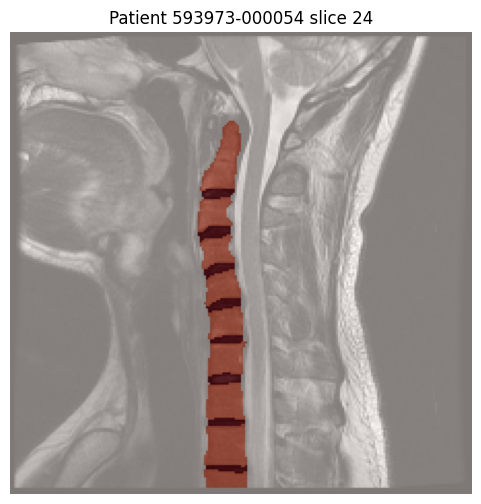

In [19]:
# Get a batch from the train loader
vol, msk, patient_id = next(iter(train_loader))

print("Volume shape:", vol.shape)       # should be (batch, 1, H, W, D)
print("Mask shape:", msk.shape)         # should be (batch, H, W, D)
print("Patient ID:", patient_id)        # should show the IDs

# Visualize the middle slice for the first patient in the batch
mid = msk.shape[-1] // 2
plt.figure(figsize=(6,6))
plt.imshow(vol[0,0,:,:,mid].cpu(), cmap="gray")
plt.imshow(msk[0,:,:,mid].cpu(), cmap="Reds", alpha=0.5)
plt.axis("off")
plt.title(f"Patient {patient_id[0]} slice {mid}")
plt.show()


Volume shape: torch.Size([2, 1, 224, 224, 48])
Mask shape:   torch.Size([2, 224, 224, 48])
Patient ID:   ['593973-000054', '593973-000282']


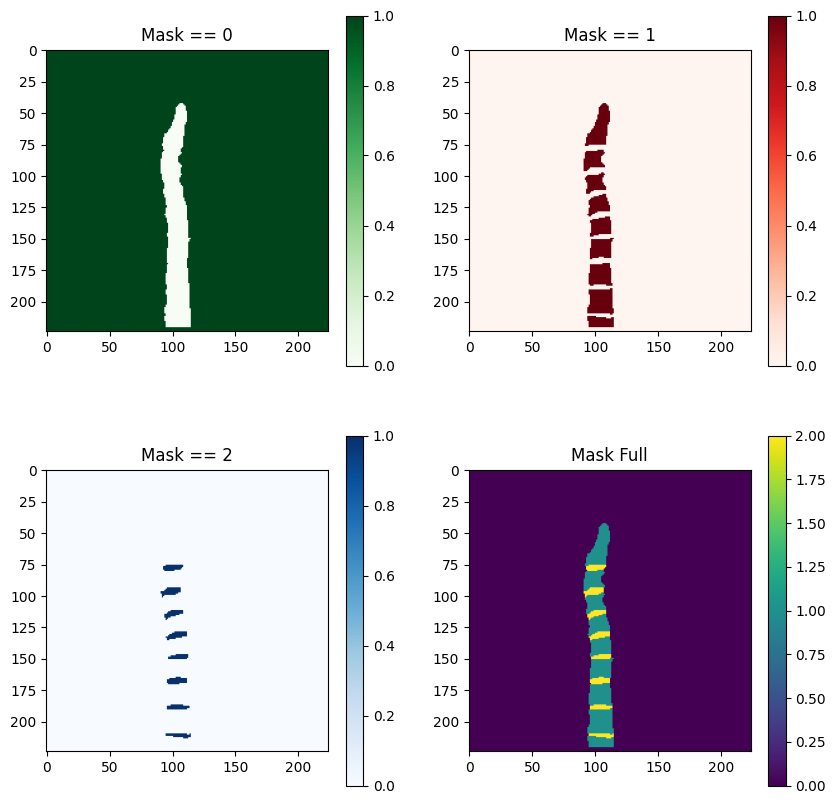

In [20]:
# vol, msk, patient_id = next(iter(train_loader))
print("Volume shape:", vol.shape)
print("Mask shape:  ", msk.shape)
print("Patient ID:  ", patient_id)

# msk shape: (1, H, W, D)
mid = msk.shape[-1] // 2   # mid slice along depth

plt.figure(figsize=(10,10))

# Class 0
plt.subplot(2,2,1)
plt.title("Mask == 0")
plt.imshow((msk[0,:,:,mid] == 0).cpu(), cmap="Greens")
plt.colorbar()

# Class 1
plt.subplot(2,2,2)
plt.title("Mask == 1")
plt.imshow((msk[0,:,: ,mid] == 1).cpu(), cmap="Reds")
plt.colorbar()

# Class 2
plt.subplot(2,2,3)
plt.title("Mask == 2")
plt.imshow((msk[0,:,: ,mid] == 2).cpu(), cmap="Blues")
plt.colorbar()

# All labels
plt.subplot(2,2,4)
plt.title("Mask Full")
plt.imshow(msk[0,:,:,mid].cpu(), cmap="viridis")
plt.colorbar()

plt.show()


In [21]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

print(f"Train sample shapes: \nVolume: {train_batch[0].shape}, Mask: {train_batch[1].shape}")
print(f"Val sample shapes: \nVolume: {val_batch[0].shape}, Mask: {val_batch[1].shape}")
print(f"Test sample shapes: \nVolume: {test_batch[0].shape}, Mask: {test_batch[1].shape}")
print("Unique mask labels:", torch.unique(test_batch[1]))


Train sample shapes: 
Volume: torch.Size([2, 1, 224, 224, 48]), Mask: torch.Size([2, 224, 224, 48])
Val sample shapes: 
Volume: torch.Size([2, 1, 224, 224, 48]), Mask: torch.Size([2, 224, 224, 48])
Test sample shapes: 
Volume: torch.Size([2, 1, 224, 224, 48]), Mask: torch.Size([2, 224, 224, 48])
Unique mask labels: tensor([0, 1, 2])


cuda


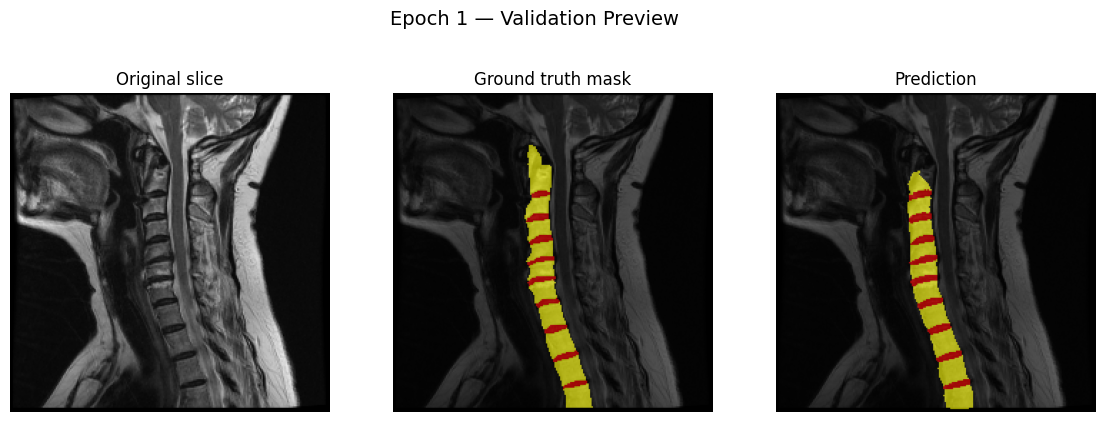

Epoch [1/8] Loss=0.0385 CE=0.0385 DiceLoss=0.9777 ValDice=0.7861 (dice_w=0.000)
🔥 Saved new best model (Dice=0.7861)


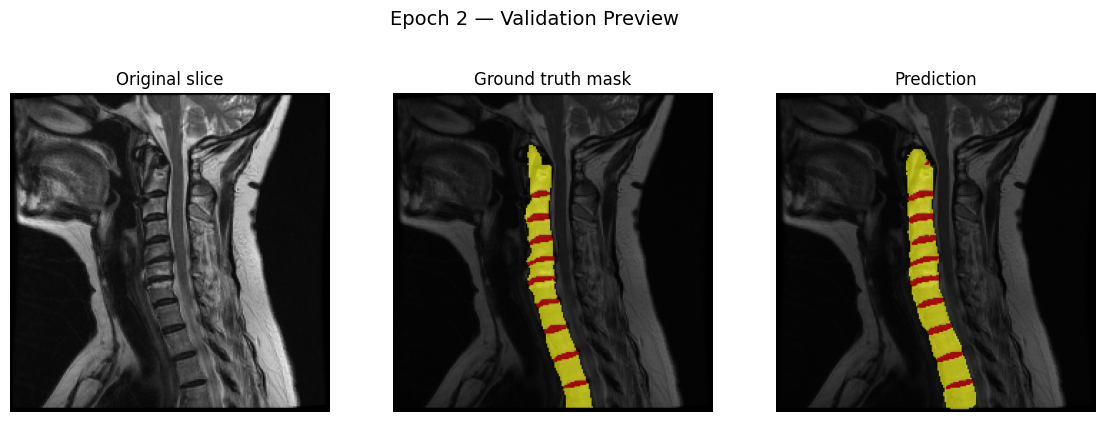

Epoch [2/8] Loss=0.0209 CE=0.0209 DiceLoss=0.9688 ValDice=0.7732 (dice_w=0.000)


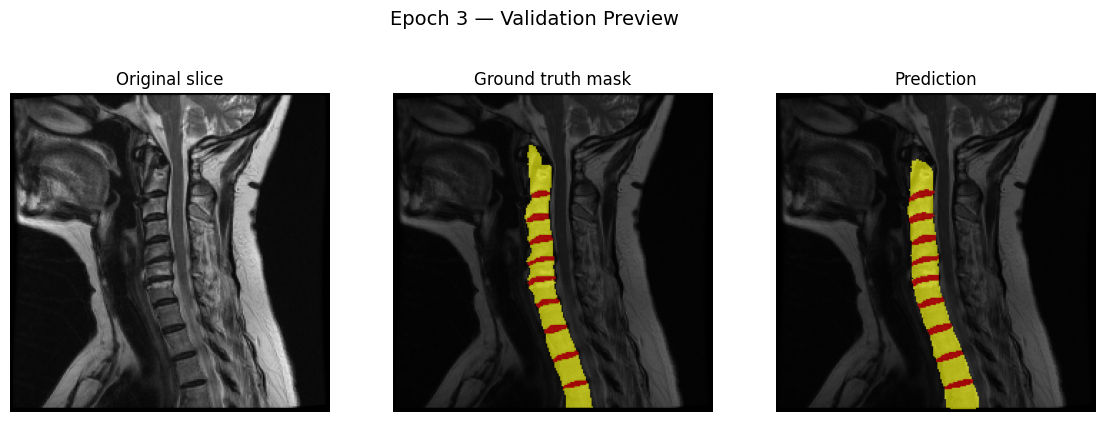

Epoch [3/8] Loss=0.0149 CE=0.0149 DiceLoss=0.9610 ValDice=0.8180 (dice_w=0.000)
🔥 Saved new best model (Dice=0.8180)


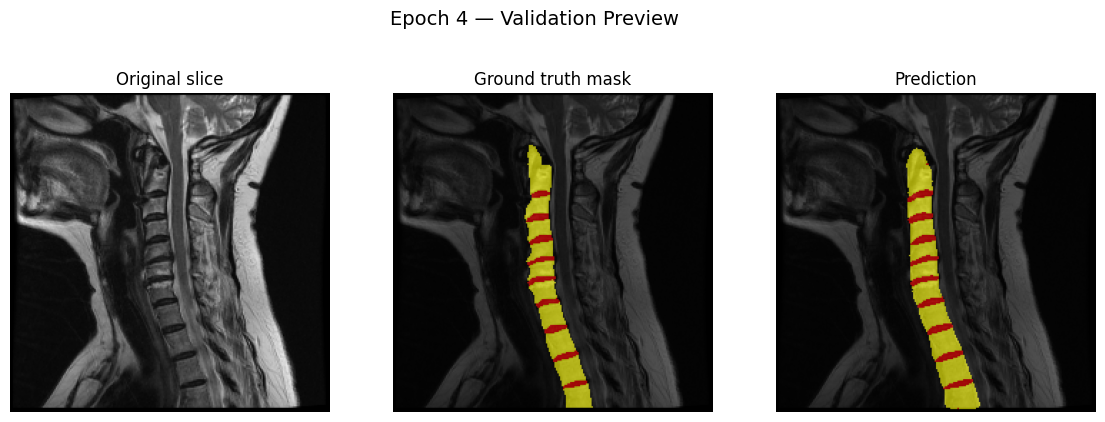

Epoch [4/8] Loss=0.0113 CE=0.0113 DiceLoss=0.9519 ValDice=0.8039 (dice_w=0.000)


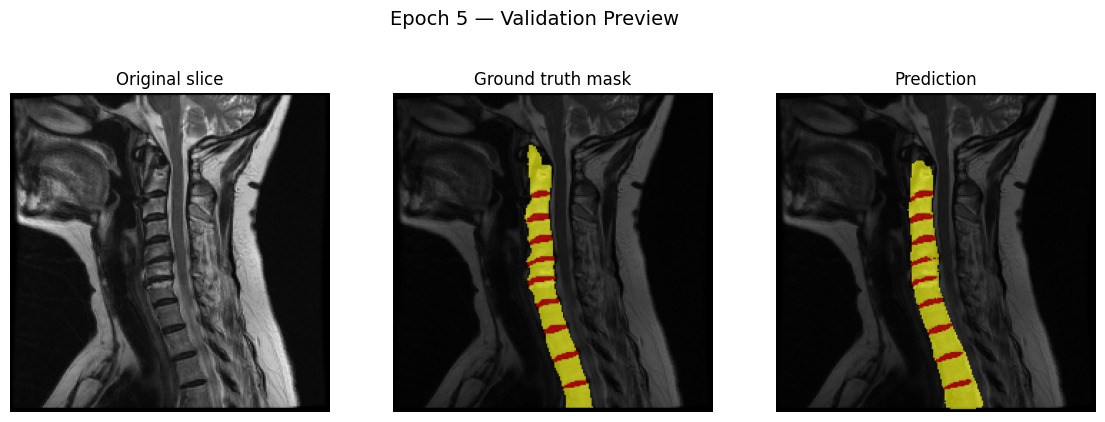

Epoch [5/8] Loss=0.0091 CE=0.0091 DiceLoss=0.9422 ValDice=0.8169 (dice_w=0.000)


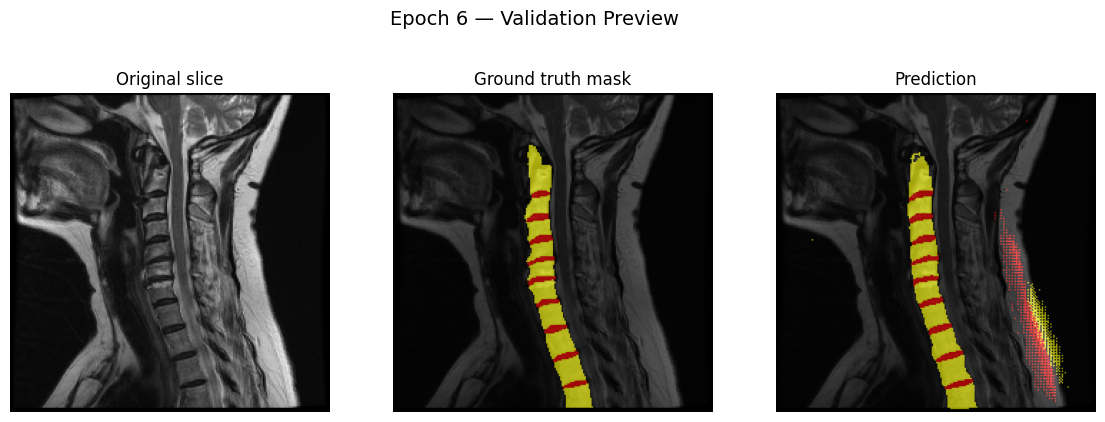

Epoch [6/8] Loss=0.0076 CE=0.0076 DiceLoss=0.9312 ValDice=0.7462 (dice_w=0.000)


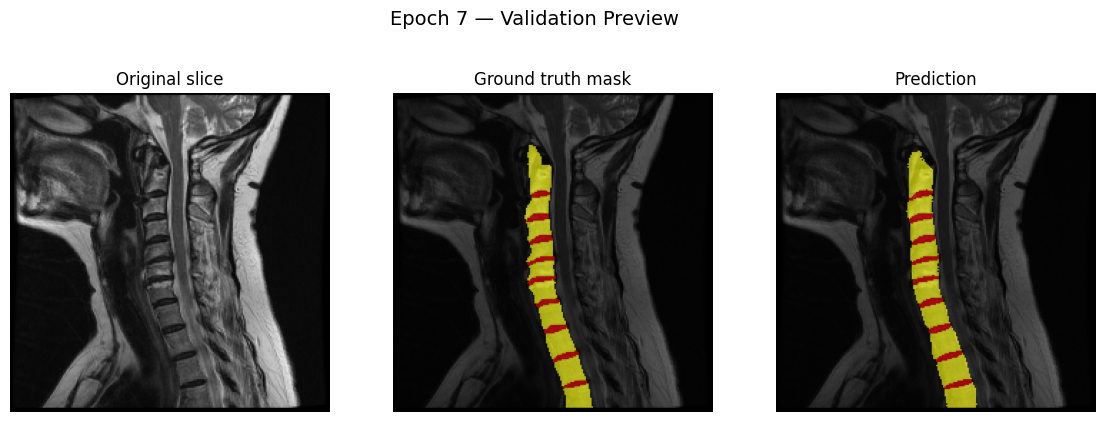

Epoch [7/8] Loss=0.0068 CE=0.0068 DiceLoss=0.9204 ValDice=0.8276 (dice_w=0.000)
🔥 Saved new best model (Dice=0.8276)


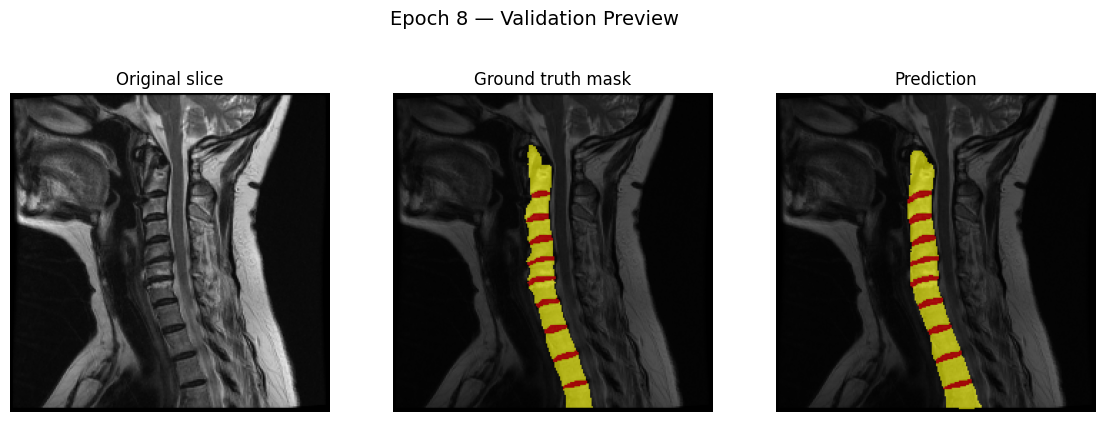

Epoch [8/8] Loss=0.0061 CE=0.0061 DiceLoss=0.9082 ValDice=0.8231 (dice_w=0.000)


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)
model_UNet, history = train_model(model_UNet, train_loader, val_loader, device, num_epochs=8, lr=5e-5, num_classes=3)

In [23]:
# import numpy as np

# from tqdm import tqdm

# counts = np.zeros(3, dtype=np.int64)

# for _, mask_path in tqdm(dataset_entries):
#     mask = dataset.load_mask(mask_path)
#     u, c = np.unique(mask, return_counts=True)
#     for val, cnt in zip(u, c):
#         counts[val] += cnt

# print("Voxel counts per class:", counts)
# print("Percentages:", counts / counts.sum())


In [24]:
# freq = counts / counts.sum()
# inv_freq = 1.0 / (freq + 1e-6)
# weights = inv_freq / inv_freq.sum()

# print("Suggested weights:", weights)


In [25]:
# import pydicom
# import nibabel as nib
# import numpy as np
# import matplotlib.pyplot as plt
# from pathlib import Path

# # -------------------------------------------------------------
# # Replace these with your actual patient entry
# # -------------------------------------------------------------
# dicom_folder, mask_path = dataset_entries[0]
# dicom_folder = Path(dicom_folder)

# # -------------------------------------------------------------
# # Load DICOM volume (sorted by InstanceNumber)
# # -------------------------------------------------------------
# dcm_files = sorted(
#     dicom_folder.glob("*.dcm"),
#     key=lambda f: int(pydicom.dcmread(f).InstanceNumber)
# )
# slices = [pydicom.dcmread(f).pixel_array for f in dcm_files]
# img_volume = np.stack(slices, axis=-1)  # shape: (H, W, D)

# # -------------------------------------------------------------
# # Load original NIfTI mask
# # -------------------------------------------------------------
# mask_nii = nib.load(mask_path)
# mask_original = mask_nii.get_fdata()    # shape: (H, W, D)

# # -------------------------------------------------------------
# # Apply your current alignment transform
# # -------------------------------------------------------------
# mask_aligned = np.rot90(mask_original, k=1)
# mask_aligned = np.flip(mask_aligned, axis=2)

# # -------------------------------------------------------------
# # Pick middle slice
# # -------------------------------------------------------------
# mid = img_volume.shape[2] // 2

# # -------------------------------------------------------------
# # Plot slices
# # -------------------------------------------------------------
# plt.figure(figsize=(18, 6))

# plt.subplot(1, 3, 1)
# plt.imshow(img_volume[:, :, mid], cmap="gray")
# plt.title("DICOM Slice (mid)")
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.imshow(mask_original[:, :, mid], cmap="viridis")
# plt.title("Original Mask Slice (before alignment)")
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.imshow(mask_aligned[:, :, mid], cmap="viridis")
# plt.title("Aligned Mask Slice (your rotation + flip)")
# plt.axis("off")

# plt.tight_layout()
# plt.show()


In [26]:
# from torch.utils.data import Subset, DataLoader

# # Keep only the first 5 samples for a quick test
# small_train_dataset = Subset(train_dataset, range(5))
# small_train_loader = DataLoader(small_train_dataset, batch_size=1, shuffle=True)

# # Similarly for validation
# small_val_dataset = Subset(val_dataset, range(5))
# small_val_loader = DataLoader(small_val_dataset, batch_size=1, shuffle=False)

# # Similarly for test
# small_test_dataset = Subset(test_dataset, range(5))
# small_test_loader = DataLoader(small_test_dataset, batch_size=1, shuffle=False)

In [27]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)

# model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)
# model_UNet, history = train_model(model_UNet, small_train_loader, small_val_loader, device, num_epochs=2, num_classes=3)

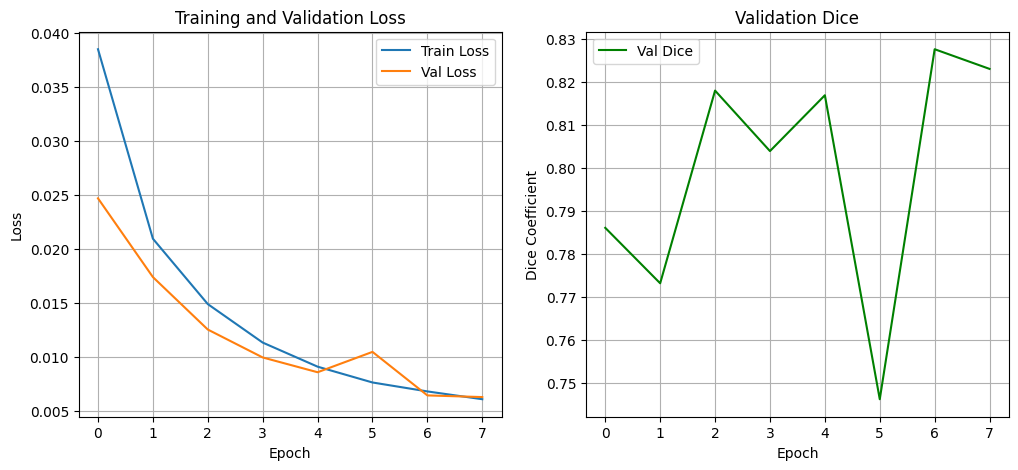

In [28]:
# Plot Loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Dice curves (validation only)
plt.subplot(1,2,2)
plt.plot(history['val_dice'], label='Val Dice', color='green')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice')
plt.legend()
plt.grid(True)

plt.show()


In [29]:
# mean_dice, class_dice, metrics = evaluate_model(model_UNet, small_test_loader, device, num_classes=3)

# print(f"Overall mean Dice: {mean_dice:.4f}")
# for i, d in enumerate(class_dice):
#     print(f"Class {i} Dice: {d:.4f}")

In [30]:
# class_names = ["Background", "Vertebrae", "Intervertebral Discs"]

# print_metrics(metrics, class_names)

In [31]:
# Save
torch.save(model_UNet.state_dict(), "../weights/unet3d_weights_v1.7.2.pth")

# Load if needed
# model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)  # same architecture
# model_UNet.load_state_dict(torch.load("pathTo.pth"))
# model_UNet.to(device)
# model_UNet.eval()  # set to evaluation mode if testing

In [32]:
# # Delete model and optimizer references (optional if you don't need them)
# del model_UNet

# # Clear CUDA cache
# torch.cuda.empty_cache()

# # Optional: collect Python garbage
# import gc
# gc.collect()

In [33]:
import torch
from spine_score.src.model import SimpleUNet3D

device = "cuda" if torch.cuda.is_available() else "cpu"

# Recreate the architecture
model_UNet = SimpleUNet3D(in_channels=1, out_channels=3)

# Load saved weights
state_dict = torch.load("../weights/unet3d_weights_v1.7.2.pth", map_location=device)
#state_dict = torch.load("best_model.pth", map_location=device)
model_UNet.load_state_dict(state_dict)

# Move to device and set to eval mode
model_UNet.to(device)
model_UNet.eval()


SimpleUNet3D(
  (encoder): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(in

Slices with foreground: tensor([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34])
Using slice: 26


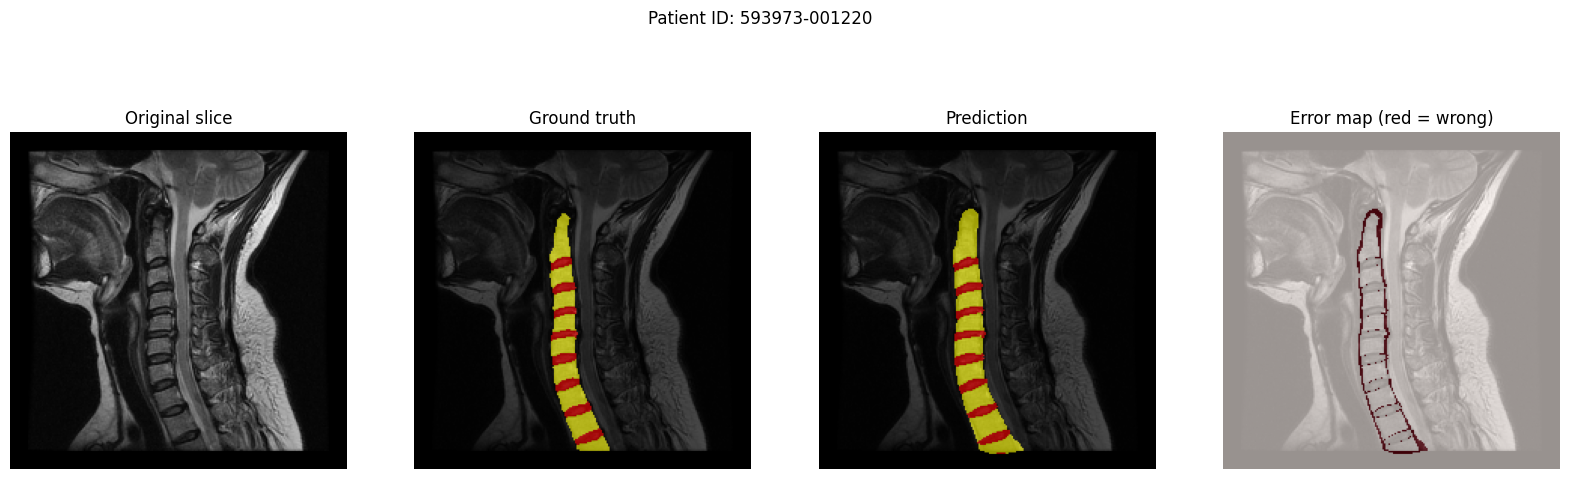

In [36]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

model_UNet.load_state_dict(torch.load("../weights/unet3d_weights_v1.7.2.pth"))
model_UNet.eval()

cmap = ListedColormap(["black", "yellow", "red"])  # background, class1, class2

# Get one batch
vol, msk, patient_id = next(iter(test_loader))
vol = vol.to(device)

# Run model
with torch.no_grad():
    logits = model_UNet(vol)                        # (B,C,H,W,D)
    probs = torch.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1)        # (B,H,W,D)

# Extract data
pred_mask = pred_labels[0].cpu()
true_mask = msk[0]
image = vol[0,0].cpu()

slices_with_fg = torch.where(true_mask.sum(dim=(0,1)) > 0)[0]
print("Slices with foreground:", slices_with_fg[:20])
mid = int(slices_with_fg[len(slices_with_fg)//2])
print("Using slice:", mid)

# Compute error map (1 = wrong prediction, 0 = correct)
error_map = (pred_mask[:,:,mid] != true_mask[:,:,mid]).float()

plt.figure(figsize=(20,6))

# Original slice
plt.subplot(1,4,1)
plt.title("Original slice")
plt.imshow(image[:,:,mid], cmap="gray")
plt.axis("off")

# Ground truth
plt.subplot(1,4,2)
plt.title("Ground truth")
plt.imshow(image[:,:,mid], cmap="gray")
plt.imshow(true_mask[:,:,mid], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
plt.axis("off")

# Prediction
plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(image[:,:,mid], cmap="gray")
plt.imshow(pred_mask[:,:,mid], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
plt.axis("off")

# Error map
plt.subplot(1,4,4)
plt.title("Error map (red = wrong)")
plt.imshow(image[:,:,mid], cmap="gray")
plt.imshow(error_map, cmap="Reds", alpha=0.6)
plt.axis("off")

plt.suptitle(f"Patient ID: {patient_id[0]}")
plt.show()


Saved GIF: ../gifs/volume_slices.gif


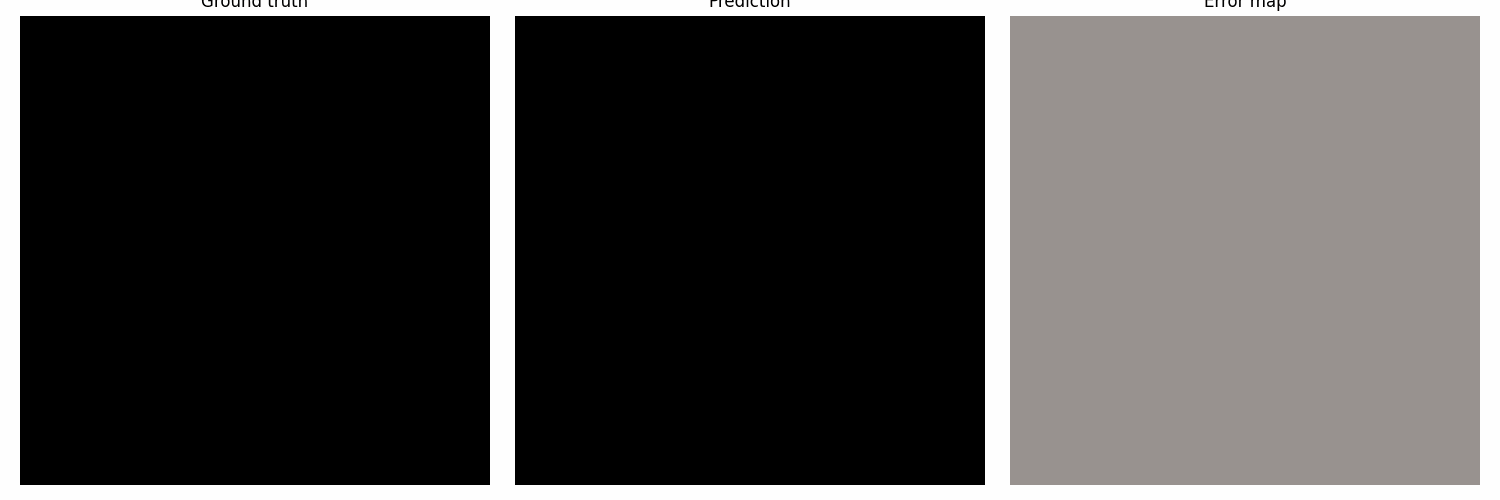

In [39]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio
from io import BytesIO
from IPython.display import Image, display

# Load model
model_UNet.load_state_dict(torch.load("../weights/unet3d_weights_v1.7.2.pth"))
model_UNet.eval()

cmap = ListedColormap(["black", "yellow", "red"])  # background, class1, class2

# Get one batch
vol, msk, patient_id = next(iter(test_loader))
vol = vol.to(device)

with torch.no_grad():
    logits = model_UNet(vol)                        # (B,C,H,W,D)
    probs = torch.softmax(logits, dim=1)
    pred_labels = torch.argmax(probs, dim=1)        # (B,H,W,D)

pred_mask = pred_labels[0].cpu()
true_mask = msk[0]
image = vol[0,0].cpu()

# Compute error map
error_map_vol = (pred_mask != true_mask).float()

frames = []

# Generate frames slice by slice
for s in range(image.shape[2]):
    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    # Ground truth
    axes[0].imshow(image[:,:,s], cmap="gray")
    axes[0].imshow(true_mask[:,:,s], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
    axes[0].set_title("Ground truth")
    axes[0].axis("off")

    # Prediction
    axes[1].imshow(image[:,:,s], cmap="gray")
    axes[1].imshow(pred_mask[:,:,s], cmap=cmap, alpha=0.6, vmin=0, vmax=2)
    axes[1].set_title("Prediction")
    axes[1].axis("off")

    # Error map
    axes[2].imshow(image[:,:,s], cmap="gray")
    axes[2].imshow(error_map_vol[:,:,s], cmap="Reds", alpha=0.6)
    axes[2].set_title("Error map")
    axes[2].axis("off")

    plt.tight_layout()

    # Save current figure to a buffer
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    frames.append(imageio.v2.imread(buf))

# Save GIF
gif_filename = "../gifs/volume_slices.gif"
imageio.mimsave(gif_filename, frames, fps=5, loop=0)
print(f"Saved GIF: {gif_filename}")

# Display inline
with open(gif_filename,'rb') as f:
    display(Image(f.read()))


In [35]:
pred_unique, pred_counts = torch.unique(pred_labels.cpu(), return_counts=True)
true_unique, true_counts = torch.unique(true_mask.cpu(), return_counts=True)

print("PRED classes:", pred_unique, pred_counts)
print("TRUE classes:", true_unique, true_counts)


PRED classes: tensor([0, 1, 2]) tensor([4692168,   98536,   26192])
TRUE classes: tensor([0, 1, 2]) tensor([2370168,   28163,   10117])
